In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:

TRAIN_PATH = "Plant Counting/train/train.tfrecord"
VALID_PATH = "Plant Counting/valid/valid.tfrecord"
TEST_PATH = "Plant Counting/test/test.tfrecord"

BATCH_SIZE = 32
EPOCHS = 100
IMG_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE

In [10]:
data = tf.data.TFRecordDataset(VALID_PATH)

In [11]:
counter = 0;
for row in data:
    example = tf.train.Example()
    example.ParseFromString(row.numpy())
    counter+=1

counter

57

In [57]:
def decode_tfrecord(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, IMG_SIZE) / 255.0
    labels_sparse = example['image/object/class/label']
    labels_dense = tf.sparse.to_dense(labels_sparse, default_value=-1)
    label = tf.cast(tf.size(labels_dense), tf.float32)
    return image, label

def load_dataset(path):
    dataset = tf.data.TFRecordDataset(path)
    dataset = dataset.map(decode_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat(30).shuffle(True).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return dataset


In [58]:
train_ds = load_dataset(TRAIN_PATH)
valid_ds = load_dataset(VALID_PATH)
test_ds = load_dataset(TEST_PATH)

In [59]:
base_model = applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1)
])


In [60]:

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3)

history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=[early_stop, reduce_lr])


Epoch 1/100


   2871/Unknown 1348s 466ms/step - loss: 8.9038 - root_mean_squared_error: 2.8600

c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2871/2871 ━━━━━━━━━━━━━━━━━━━━ 1373s 475ms/step - loss: 8.9021 - root_mean_squared_error: 2.8597 - val_loss: 14.8429 - val_root_mean_squared_error: 3.8526 - learning_rate: 0.0010
Epoch 2/100
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 2100s 732ms/step - loss: 0.9999 - root_mean_squared_error: 0.9955 - val_loss: 23.0499 - val_root_mean_squared_error: 4.8010 - learning_rate: 0.0010
Epoch 3/100
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 1902s 663ms/step - loss: 0.7563 - root_mean_squared_error: 0.8678 - val_loss: 18.5627 - val_root_mean_squared_error: 4.3084 - learning_rate: 0.0010
Epoch 4/100
2871/2871 ━━━━━━━━━━━━━━━━━━━━ 2459s 856ms/step - loss: 0.5542 - root_mean_squared_error: 0.7416 - val_loss: 38.5669 - val_root_mean_squared_error: 6.2102 - learning_rate: 0.0010


<Axes: >

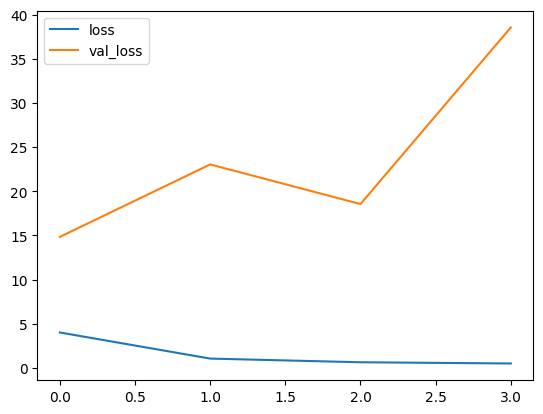

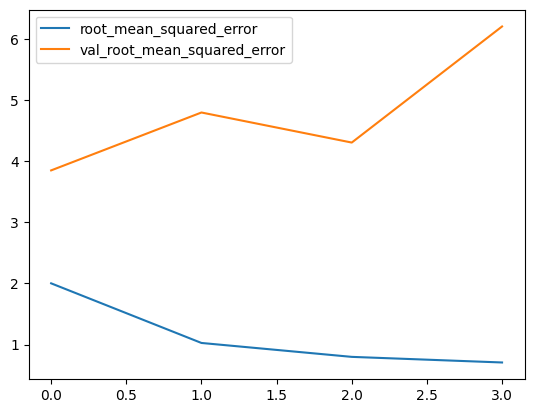

In [61]:
df = pd.DataFrame(history.history)
df.loc[:, ['loss', 'val_loss']].plot()
df.loc[:, ['root_mean_squared_error', 'val_root_mean_squared_error']].plot()

In [52]:
results = model.evaluate(test_ds)
y_true = []
y_pred = []



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 105.3171 - root_mean_squared_error: 10.2624


c:\Users\amany\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 916ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1

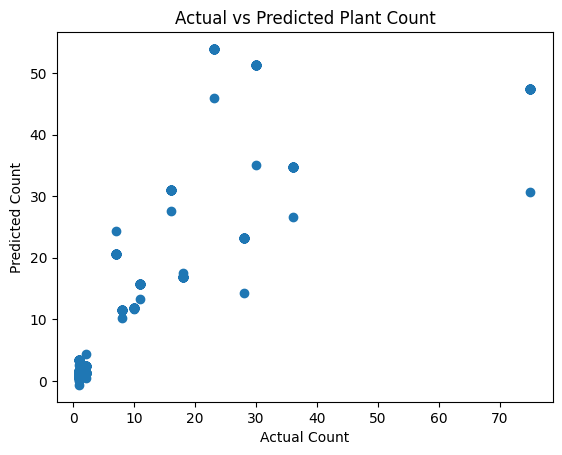

In [62]:
for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

plt.scatter(y_true, y_pred)
plt.xlabel('Actual Count')
plt.ylabel('Predicted Count')
plt.title('Actual vs Predicted Plant Count')
plt.show()


In [63]:
rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
r2 = 1 - (np.sum((np.array(y_true) - np.array(y_pred)) ** 2) / np.sum((np.array(y_true) - np.mean(y_true)) ** 2))

print("Test RMSE:", rmse)
print("Test R²:", r2)



Test RMSE: 9.284345
Test R²: 0.6416482627391815


In [ ]:

model.save('Plant_Counting_Upgraded_Model.keras')